In [1]:
import sympy as sp # Symbolic maths
import lcapy as lp # Symbolic circuit analysis
import numpy as np # Numerical maths

import matplotlib.pyplot as plt # Plots and graphs
import matplotlib.ticker as ticker


# Style plots

plt.style.use('bmh')

tex_fonts = {
    # Use LaTeX to write all text
    "pgf.texsystem": "pdflatex",
    "text.usetex": True,
    "font.family": "sans-serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)


FIRST-ORDER RC HIGH-PASS FILTER




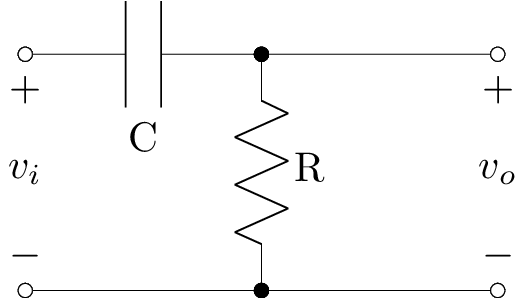

In [2]:
'''
Draw schematic
'''

print("FIRST-ORDER RC HIGH-PASS FILTER")
print("\n")

rchp1 = lp.Circuit("""
    P1 1 0; down, v=v_i
    C 1 2; right, C
    W  0 0_1; right
    R 2 0_1; down, R
    W 0_1 0_2; right
    W 2 2_1; right
    P2 2_1 0_2; down, v=v_o
""")

rchp1.draw(style="american", draw_nodes="connections", label_nodes="none", scale=2)

rchp1.draw("RcHp1_schem.png",  style="american", draw_nodes="connections", label_nodes="none", \
             cpt_size=1, scale=2)

In [3]:
'''
Find analog transfer function
'''

print("ANALOG TRANSFER FUNCTION")
print("\n")
print("H(s)=")
Hs = rchp1.transfer('P1', 'P2').simplify()

sp.pretty_print(Hs)
print("\n")
sp.print_latex(Hs)

ANALOG TRANSFER FUNCTION


H(s)=
  C⋅R⋅s  
─────────
C⋅R⋅s + 1


\frac{C R s}{C R s + 1}


In [4]:
'''
Express H(s) in terms of (angular) cutoff frequency
'''

# Get symbols from lcapy context for further calculations using sympy
C = lp.state.context.symbols.C
R = lp.state.context.symbols.R

# Define new symbol angular cutoff frequency
w0 = sp.symbols("omega0")

# Transform lcapy transfer function into regular sympy expression
Hs = Hs.sympy.simplify()

# Substitute
Hs = Hs.subs(R*C, sp.S.One / w0)

print("H(s)=")
sp.pretty_print(Hs)
print("\n")
sp.print_latex(Hs)

H(s)=
     s     
───────────
   ⎛    s ⎞
ω₀⋅⎜1 + ──⎟
   ⎝    ω₀⎠


\frac{s}{\omega_{0} \left(1 + \frac{s}{\omega_{0}}\right)}


In [5]:
'''
Bilinear transformation with prewarping
'''

# Get some more symbols from lcapy context
s = lp.state.context.symbols.s
f = lp.state.context.symbols.f

# Define some more symbols
z = sp.symbols("z")
f0, T = sp.symbols("f0, T", real=True)

# Define substitution
blt = (w0 / sp.tan(w0 * T / 2)) * (z - 1) / (z + 1)

print("SUBSTITUTE FOR s VARIALBE\n")
sp.pretty_print(blt)
print("\n")
sp.print_latex(blt)

SUBSTITUTE FOR s VARIALBE

    ω₀⋅(z - 1)   
─────────────────
           ⎛T⋅ω₀⎞
(z + 1)⋅tan⎜────⎟
           ⎝ 2  ⎠


\frac{\omega_{0} \left(z - 1\right)}{\left(z + 1\right) \tan{\left(\frac{T \omega_{0}}{2} \right)}}


In [6]:
'''
Discretisation step
'''

# Do the substitution to find digital model
Hz = Hs.subs(s, blt).simplify()

print("DIGITAL TRANSFER FUNCTION")
print("\n")
print("H(z)=")

sp.pretty_print(Hz)
print("\n")
sp.print_latex(Hz)

DIGITAL TRANSFER FUNCTION


H(z)=
          z - 1          
─────────────────────────
               ⎛T⋅ω₀⎞    
z + (z + 1)⋅tan⎜────⎟ - 1
               ⎝ 2  ⎠    


\frac{z - 1}{z + \left(z + 1\right) \tan{\left(\frac{T \omega_{0}}{2} \right)} - 1}


In [7]:
'''
Simplify for more efficient implementation
'''

Hz = Hz.subs(sp.tan(w0*T/2), w0*T/2).simplify()

sp.pretty_print(Hz)
print("\n")
sp.print_latex(Hz)

      2⋅(z - 1)       
──────────────────────
T⋅ω₀⋅(z + 1) + 2⋅z - 2


\frac{2 \left(z - 1\right)}{T \omega_{0} \left(z + 1\right) + 2 z - 2}


In [8]:
'''
Substitute component values before evaluating
'''

# ANALOG

# Define actual component values. (These can be calculated for any given cutoff frequency)
Rval = 2200 # Ohm
Cval = 100e-9 # Farad

print(f"R = {Rval: 1.0f} Ohm, C = {Cval * 1e9} nF")
print(f"CUTOFF FREQUENCY: {1 / (2 * np.pi * Rval * Cval): 4.0f} Hz")
print("\n")

HsEval = Hs.subs(w0, 1 / (Rval * Cval)) # (This does not take into account any physical units!)

print("H(s)=")
sp.pretty_print(HsEval)
print("\n")
sp.print_latex(HsEval)

# DIGITAL

# Input same component values
HzEval = Hz.subs(w0, 1/(Rval * Cval))

# Sampling interval
fsVal = 48000 # Hertz
TVal = 1 / fsVal # Second

# Plug in sampling interval
HzEval = HzEval.subs(T, TVal)

print("\n")
print("H(z)=")
sp.pretty_print(HzEval)
print("\n")
sp.print_latex(HzEval)

R =  2200 Ohm, C = 100.0 nF
CUTOFF FREQUENCY:  723 Hz


H(s)=
  0.00022⋅s  
─────────────
0.00022⋅s + 1


\frac{0.00022 s}{0.00022 s + 1}


H(z)=
              2⋅(z - 1)              
─────────────────────────────────────
2.09469696969697⋅z - 1.90530303030303


\frac{2 \left(z - 1\right)}{2.09469696969697 z - 1.90530303030303}


In [9]:
'''
Evaluate frequency response to find magnitude and phase
'''

# ANALOG

# Create frequency vector
fVals = 20 * np.logspace(0, 3, 300) # 20Hz - 20kHz

# Evaluate the analog transfer function at s=jw to find frequency response
sSub = 1j * 2 * np.pi * f 
HsEval = HsEval.subs(s, sSub)

# Make Hs a callable function, so numpy arrays work as input
Hs_f = sp.lambdify(f, HsEval, "numpy") # H_s(f)

# Find magnitude and phase
sFreqResp = Hs_f(fVals)
sMag = 20 * np.log10(np.abs(sFreqResp))
sPhase = np.angle(sFreqResp)

# DIGITAL

# Make Hs a callable function, so numpy arrays work as input
Hz_f = sp.lambdify(z, HzEval, "numpy")

# Evaluate at z = exp(jwT) to find frequency response
zSub = np.exp(1j * 2 * np.pi * fVals * TVal)
zFreqResp = Hz_f(zSub)

# Find magnitude and phase
zMag = 20 * np.log10(np.abs(zFreqResp))
zPhase = np.angle(zFreqResp)

COMPARING BOTH MODELS
(fs =  48000 Hz)




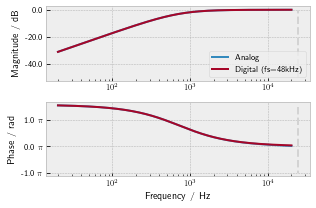

In [10]:
# Create Bode plot
fig, ax = plt.subplots(2, 1, sharex=False, sharey=False, figsize=(4.5, 3))
print("COMPARING BOTH MODELS")
print(f"(fs = {fsVal: 1.0f} Hz)")
print("\n")

ax[0].yaxis.set_major_formatter(ticker.FormatStrFormatter(r'%.1f'))
ax[1].yaxis.set_major_formatter(ticker.FormatStrFormatter(r'%.1f $\pi$'))

ax[0].semilogx(fVals, sMag, label="Analog")
ax[0].semilogx(fVals, zMag, label=r"Digital (fs=48kHz)")
ax[0].set_ylabel("Magnitude / dB")
ax[0].legend()
ax[0].vlines(fsVal / 2, -50, 0, color="lightgrey", linestyle="dashed")

ax[1].semilogx(fVals, zPhase)
ax[1].semilogx(fVals, sPhase)
ax[1].set_xlabel("Frequency / Hz")
ax[1].set_ylabel("Phase / rad")

ax[1].vlines(fsVal / 2, 1.5, -1.0, color="lightgrey", linestyle="dashed")

plt.tight_layout()
plt.savefig("RcHp1_bode.png", dpi=300)

In [12]:
'''
Find coefficients
'''
# Get numerator / denominator coefficients

num, den = Hz.as_numer_denom()

numCoeffs = num.as_expr().as_poly(z).simplify().coeffs()
denCoeffs = den.as_expr().as_poly(z).simplify().coeffs()

# Normalize coefficient b0 to 1 (divide all coeffs by b0)

b0 = denCoeffs[0]
numCoeffsNorm = []
denCoeffsNorm = []

for coeff in numCoeffs:
    coeff /= b0
    numCoeffsNorm.append(coeff)
for coeff in denCoeffs:
    coeff /= b0
    denCoeffsNorm.append(coeff)

print("COEFFICIENTS")
print("\n")
print("a0: ", numCoeffsNorm[0])
print("a1: ", numCoeffsNorm[1])
print("a2: ", 0.0)
print("b0: ", denCoeffsNorm[0])
print("b1: ", denCoeffsNorm[1])
print("b2: ", 0.0)

COEFFICIENTS


a0:  2/(T*omega0 + 2)
a1:  -2/(T*omega0 + 2)
a2:  0.0
b0:  1
b1:  (T*omega0 - 2)/(T*omega0 + 2)
b2:  0.0
